# NN2
Tymoteusz Urban

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import copy
from tqdm import tqdm

In [13]:
class NeuralNetwork:
    
    """
    Implementation of multi layer perceptron

    Attributes
    -----------
    layers : List
    
    """
    
    def __init__(self, layers, weights=None, biases=None, activations=None, initalization='xavier'):
        """
        activations - available functions: 'sigmoid', 'linear'
        initialization - available types: 'xavier', 'he', 'uniform'
        """
        self.layers = layers
        self.num_layers = len(layers)
        
        initialization_functions = {
            'xavier': self.xavier_init,
            'he': self.he_init,
            'uniform': self.uniform_init
        }
        self.init_function = initialization_functions.get(initalization)
        
        if weights is None:
            self.weights = [self.init_function(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [self.init_function(layers[i]) for i in range(1, self.num_layers)]
        else:
            self.biases = biases
        
        if activations is None:
            self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['linear']
        else:
            self.activations = activations
        
        self.velocities_weights = [self.zeros_init(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        self.velocities_biases = [self.zeros_init(layers[i]) for i in range(1, self.num_layers)]
        
        activation_functions = {
            'sigmoid': self._sigmoid,
            'linear': self._linear
        }
        self.activation_funcs = list(map(lambda x: activation_functions.get(x), self.activations))
        
        self.mean = None
        self.std = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _linear(self, z):
        return z
    
    def xavier_init(self, n_in, n_out=None):
        if n_out is None:
            n_out = n_in
            variance = 1 / n_out
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_out)
        variance = 2 / (n_in + n_out)
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
        
    def he_init(self, n_in, n_out=None):
        if n_out is None:
            variance = 2 / n_in
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_in)
        variance = 2 / n_in
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
    
    def zeros_init(self, n_in, n_out=None):
        if n_out is None:
            return np.zeros(n_in)
        return np.zeros((n_in, n_out))
    
    def uniform_init(self, n_in, n_out=None):
        if n_out is None:
            return np.random.uniform(0, 1, n_in)
        return np.random.uniform(0, 1, (n_in, n_out))
    
    def feedforward(self, a, return_activations=False):
        if return_activations:
            activations = [a]
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
                activations.append(a)
            return activations
        else:
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
            return a
    
    def predict(self, X):
        return self.feedforward(X)
    
    def mse(self, X, y, resize=False, denormalize=None):
        """
        first predictions are made, then denormalized and then mse is calculated
        
        denormalize - a tuple (mean, std)
        """
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
        predictions = self.predict(X)
        if denormalize:
            predictions = destandardize_data(predictions, denormalize)
        return np.mean((predictions - y) ** 2)
    
    def sigmoid_derivative(self, a):
        """calculates sigm'(z) where a = sigm(z)"""
        return a * (1-a)
    
    def backward(self, X, y):
        """backpropagation, returns partial derevatives"""
        # feedforward
        activations = self.feedforward(X, return_activations=True)
        deltas = [None] * len(self.weights)
        # output error
        deltas[-1] = activations[-1] - y.reshape(-1, 1)
        # calculate neurons' errors using backpropagation 
        for i in reversed(range(len(deltas) - 1)):
            if self.activations[i] == "sigmoid":
                # calculate error delta_l = delta_{l+1} x w_{l+1} * sigmoid'(a_{l+1})
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            elif self.activations[i] == "linear":
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T)
        
        L = len(self.weights)
        weights_gradient = [None] * L
        biases_gradient = [None] * L
        # calculate partial derevatives of cost function
        for i in range(L):
            # activations array is longer (so activations[l] in reality is a_{l-1})
            weights_gradient[i] = np.dot(activations[i].T, deltas[i])
            biases_gradient[i] = np.sum(deltas[i], axis=0)
            
        return weights_gradient, biases_gradient
        
    def update_weights(self, X, y, learning_rate, optimize=None, optimize_param=0.9):
        """
        updates weights using gradient descent
        """
        m = len(X)
        weights_gradient, biases_gradient = self.backward(X, y)
        for i in range(len(self.weights)):
            
            if optimize is None:
                self.weights[i] = self.weights[i] - (learning_rate/m) * weights_gradient[i]
                self.biases[i] = self.biases[i] - (learning_rate/m) * biases_gradient[i]
            
            elif optimize == 'moment':
                self.velocities_weights[i] = weights_gradient[i] + self.velocities_weights[i] * optimize_param
                self.velocities_biases[i] = biases_gradient[i] + self.velocities_biases[i] * optimize_param
            
                self.weights[i] = self.weights[i] - (learning_rate/m) * self.velocities_weights[i]
                self.biases[i] = self.biases[i] - (learning_rate/m) * self.velocities_biases[i]            
            
            elif optimize == 'rmsprop':
                self.velocities_weights[i] = optimize_param * self.velocities_weights[i] + (1-optimize_param) * (weights_gradient[i]**2)
                self.velocities_biases[i] = optimize_param * self.velocities_biases[i] + (1-optimize_param) * (biases_gradient[i]**2)
                
                self.weights[i] = self.weights[i] - (learning_rate/m) * (weights_gradient[i]/np.sqrt(self.velocities_weights[i]))
                self.biases[i] = self.biases[i] - (learning_rate/m) * (biases_gradient[i]/np.sqrt(self.velocities_biases[i]))
    
    def create_batches(self, X, y, batch_size):
        N = len(X)
        combined_data = np.array(list(zip(X, y)))
        np.random.shuffle(combined_data)

        X_shuffled = np.array(list(zip(*combined_data))[0])
        y_shuffled = np.array(list(zip(*combined_data))[1])

        X_mini_batches = [X_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        y_mini_batches = [y_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        return X_mini_batches, y_mini_batches
        
    def train(self, X, y, learning_rate=0.001, epochs=10000, batch_size=None, return_history=False, 
              optimize=None, optimize_param=0.9,
              X_test=None, y_test=None, cutoff=None, resize=False, denormalize=None, info_interval=500, mute_print=False):
        """
        To test and print MSE on testset, X_test and y_test need to be provided
        To set early stopping, provide cutoff (and test sets)
        denormalize: a tuple (mean, std) for denormalizing target for calculating mse
        info_interval: number of epochs between logging, set to None to turn off console output
        optimize: 'moment' or 'rmsprop'
        """
        assert optimize is None or optimize in ['moment', 'rmsprop'], f"optimize should be None or in ['moment', 'rmsprop']"
        
        test_mse = False
        if X_test is not None and y_test is not None:
            test_mse = True
        early_stopping = False
        if test_mse and cutoff is not None:
            early_stopping = True
        
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
            if test_mse:
                X_test = X_test.to_numpy().reshape(-1, 1)
                y_test = y_test.to_numpy().reshape(-1, 1)
            
        if batch_size is None:
            batch_size = len(X)
        
        y_mse = y
        if denormalize is not None:
            y_mse = destandardize_data(y, denormalize)
            
        history = History()
        
        for epoch in range(1, epochs+1):
            
            if batch_size < len(X):
                batches_x, batches_y = self.create_batches(X, y, batch_size)
                for i in range(len(batches_x)):
                    self.update_weights(batches_x[i], batches_y[i], learning_rate, optimize, optimize_param)
            else:
                self.update_weights(X, y, learning_rate, optimize, optimize_param)
            
            if info_interval is not None and epoch % info_interval == 0:
                loss = self.mse(X, y_mse, denormalize=denormalize)    
                history.loss.append(loss)
                history.loss_epochs.append(epoch)
                training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                if test_mse:
                    loss_test = self.mse(X_test, y_test, denormalize=denormalize)
                    history.test_loss.append(loss_test)
                    training_info += f" Test Loss = {round(loss_test, 3)}"
                if not mute_print:
                    print(training_info)
            
            history.weights.append(copy.deepcopy(self.weights))
            history.biases.append(copy.deepcopy(self.biases))
            
            if early_stopping:
                loss_es = self.mse(X_test, y_test, denormalize=denormalize)
                if loss_es < cutoff:
                    loss = self.mse(X, y_mse, denormalize=denormalize)    
                    training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                    loss_test = self.mse(X_test, y_test, denormalize=denormalize)
                    training_info += f" Test Loss = {round(loss_test, 3)}"
                    print(training_info)
                    break
        
        if return_history:
            return history

def standardize_data(X):
    """
    returns:
    X_new - standardized X
    a tuple (mean, std) - normal distribution parameters from X for destandarizing
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

def destandardize_data(X, parameters):
    """parameters: a tuple (mean, std)"""
    return X * parameters[1] + parameters[0]

    
class History:
    """
    Class which attributes are weights from all training epochs 
    and loss for chosen loss_epochs (usually epochs with some interval)
    """
    
    def __init__(self):
        self.weights = []
        self.biases = []
        self.loss = []
        self.test_loss = []
        self.loss_epochs = []
    
    def plot_weights(self, layer, bias=False, return_plot=False):
        """
        layer - integer, index of weights vector
        if to plot bias instead of weights 
        """
        weights = []
        weights_type = 'Weights'
        if bias:
            weights_type = 'Biases'
            for epoch in self.biases:
                weights.append(epoch[layer].flatten())
        else:
            for epoch in self.weights:
                weights.append(epoch[layer].flatten())

        weights = np.array(weights)
        for i in range(weights.shape[1]):
            w_y = weights[:,i]
            plt.plot(range(len(self.weights)), w_y)
            
        plt.xlabel('Epochs')
        plt.title(f'{weights_type} values vs epochs at layer {layer}')
        if return_plot:
            return plt
        else:
            plt.show()
        
    def plot_loss(self, test=False, return_plot=False):
        if test:
            plt.plot(self.loss_epochs, self.test_loss)
            plt.title('Test loss history')
        else:
            plt.plot(self.loss_epochs, self.loss)
            plt.title('Training loss history')
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        if return_plot:
            return plt
        else:
            plt.show()

## Kryteria MSE

### Zbiór square-large

In [3]:
square_large_test = pd.read_csv("../dane/regression/square-large-test.csv", index_col=0)
square_large_train = pd.read_csv("../dane/regression/square-large-training.csv", index_col=0)

In [144]:
mlp = NeuralNetwork([1,10,1])
y_norm, parameters = standardize_data(square_simple_train['y'])
history = mlp.train(square_large_train['x'], y_norm, learning_rate=0.1, epochs=1000000, batch_size=50, return_history=True, resize=True,
                   X_test=square_large_test['x'], y_test=square_large_test['y'], cutoff=1, denormalize=parameters, info_interval=100,
                   optimize='rmsprop', optimize_param=0.9)

Epoch 100: Loss = 5775.864 Test Loss = 11278.879
Epoch 200: Loss = 1418.55 Test Loss = 4308.381
Epoch 300: Loss = 102.581 Test Loss = 990.17
Epoch 400: Loss = 30.234 Test Loss = 457.296
Epoch 500: Loss = 8.765 Test Loss = 219.607
Epoch 600: Loss = 2.971 Test Loss = 128.837
Epoch 700: Loss = 1.803 Test Loss = 96.495
Epoch 800: Loss = 1.444 Test Loss = 83.957
Epoch 900: Loss = 1.246 Test Loss = 76.967
Epoch 1000: Loss = 1.237 Test Loss = 78.318
Epoch 1100: Loss = 1.453 Test Loss = 70.398
Epoch 1200: Loss = 1.121 Test Loss = 70.216
Epoch 1300: Loss = 1.153 Test Loss = 71.54
Epoch 1400: Loss = 0.938 Test Loss = 64.711
Epoch 1500: Loss = 1.12 Test Loss = 62.151
Epoch 1600: Loss = 1.1 Test Loss = 63.6
Epoch 1700: Loss = 0.764 Test Loss = 61.949
Epoch 1800: Loss = 0.713 Test Loss = 57.893
Epoch 1900: Loss = 0.919 Test Loss = 54.579
Epoch 2000: Loss = 0.664 Test Loss = 54.024
Epoch 2100: Loss = 0.993 Test Loss = 52.717
Epoch 2200: Loss = 0.598 Test Loss = 51.154
Epoch 2300: Loss = 0.652 Test L

Epoch 18900: Loss = 0.132 Test Loss = 7.927
Epoch 19000: Loss = 0.084 Test Loss = 7.453
Epoch 19100: Loss = 0.173 Test Loss = 6.141
Epoch 19200: Loss = 0.056 Test Loss = 6.213
Epoch 19300: Loss = 0.2 Test Loss = 6.064
Epoch 19400: Loss = 0.101 Test Loss = 6.327
Epoch 19500: Loss = 0.119 Test Loss = 6.421
Epoch 19600: Loss = 0.266 Test Loss = 6.616
Epoch 19700: Loss = 0.15 Test Loss = 6.046
Epoch 19800: Loss = 0.155 Test Loss = 6.014
Epoch 19900: Loss = 0.111 Test Loss = 6.521
Epoch 20000: Loss = 0.183 Test Loss = 6.345
Epoch 20100: Loss = 0.098 Test Loss = 6.322
Epoch 20200: Loss = 0.116 Test Loss = 6.158
Epoch 20300: Loss = 0.308 Test Loss = 5.912
Epoch 20400: Loss = 0.138 Test Loss = 6.364
Epoch 20500: Loss = 0.077 Test Loss = 6.135
Epoch 20600: Loss = 0.132 Test Loss = 6.267
Epoch 20700: Loss = 0.247 Test Loss = 5.952
Epoch 20800: Loss = 0.19 Test Loss = 7.26
Epoch 20900: Loss = 0.104 Test Loss = 7.53
Epoch 21000: Loss = 0.181 Test Loss = 7.601
Epoch 21100: Loss = 0.132 Test Loss = 

Epoch 37700: Loss = 0.126 Test Loss = 3.655
Epoch 37800: Loss = 0.098 Test Loss = 3.655
Epoch 37900: Loss = 0.108 Test Loss = 3.555
Epoch 38000: Loss = 0.131 Test Loss = 3.846
Epoch 38100: Loss = 0.053 Test Loss = 3.665
Epoch 38200: Loss = 0.05 Test Loss = 3.746
Epoch 38300: Loss = 0.168 Test Loss = 3.574
Epoch 38400: Loss = 0.176 Test Loss = 3.427
Epoch 38500: Loss = 0.11 Test Loss = 3.606
Epoch 38600: Loss = 0.072 Test Loss = 3.672
Epoch 38700: Loss = 0.155 Test Loss = 3.275
Epoch 38800: Loss = 0.07 Test Loss = 3.509
Epoch 38900: Loss = 0.098 Test Loss = 3.319
Epoch 39000: Loss = 0.229 Test Loss = 3.496
Epoch 39100: Loss = 0.051 Test Loss = 3.636
Epoch 39200: Loss = 0.029 Test Loss = 3.664
Epoch 39300: Loss = 0.069 Test Loss = 3.51
Epoch 39400: Loss = 0.024 Test Loss = 3.73
Epoch 39500: Loss = 0.173 Test Loss = 3.268
Epoch 39600: Loss = 0.098 Test Loss = 3.446
Epoch 39700: Loss = 0.201 Test Loss = 3.425
Epoch 39800: Loss = 0.105 Test Loss = 3.406
Epoch 39900: Loss = 0.138 Test Loss =

In [146]:
print("MSE:", mlp.mse(square_simple['x'], square_simple['y'], resize=True, denormalize=parameters))

MSE: 0.9970608658810338


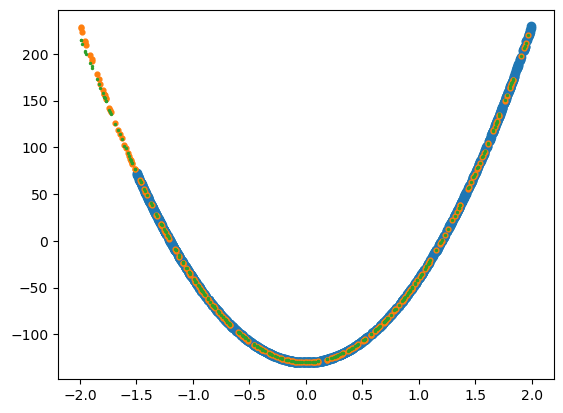

In [148]:
y_pred = mlp.predict(square_simple_test['x'].to_numpy().reshape(-1,1))
y_pred = destandardize_data(y_pred, parameters=parameters)
plt.scatter(square_simple_train['x'], square_simple_train['y'])
plt.scatter(square_simple_test['x'], square_simple_test['y'], s=12)
plt.scatter(square_simple_test['x'], y_pred, s=2)
plt.show()

### Zbiór steps-large

In [4]:
steps_large_test = pd.read_csv("../dane/regression/steps-large-test.csv", index_col=0)
steps_large_train = pd.read_csv("../dane/regression/steps-large-training.csv", index_col=0)

In [119]:
mlp_steps = NeuralNetwork([1,5,5,1], initalization='he')
y_norm_steps, parameters_steps = standardize_data(steps_large_train['y'])
history_steps = mlp_steps.train(steps_large_train['x'], y_norm_steps, learning_rate=0.2, epochs=10000, return_history=True,
                                resize=True, X_test=steps_large_test['x'], y_test=steps_small_test['y'], cutoff=3,
                                denormalize=parameters_steps, info_interval=10, batch_size=10, optimize='rmsprop')

Epoch 10: Loss = 90.996 Test Loss = 82.794
Epoch 20: Loss = 161.887 Test Loss = 162.485
Epoch 30: Loss = 57.329 Test Loss = 70.766
Epoch 40: Loss = 64.683 Test Loss = 86.866
Epoch 50: Loss = 44.34 Test Loss = 39.355
Epoch 60: Loss = 31.85 Test Loss = 35.654
Epoch 70: Loss = 32.198 Test Loss = 34.767
Epoch 80: Loss = 24.627 Test Loss = 23.471
Epoch 90: Loss = 23.313 Test Loss = 18.808
Epoch 100: Loss = 24.716 Test Loss = 15.113
Epoch 110: Loss = 22.494 Test Loss = 15.73
Epoch 120: Loss = 19.367 Test Loss = 13.309
Epoch 130: Loss = 39.098 Test Loss = 39.52
Epoch 140: Loss = 25.9 Test Loss = 21.772
Epoch 150: Loss = 41.682 Test Loss = 19.498
Epoch 160: Loss = 23.619 Test Loss = 13.151
Epoch 170: Loss = 28.635 Test Loss = 32.841
Epoch 180: Loss = 34.92 Test Loss = 44.575
Epoch 190: Loss = 39.011 Test Loss = 16.7
Epoch 200: Loss = 24.11 Test Loss = 17.622
Epoch 210: Loss = 17.373 Test Loss = 15.729
Epoch 220: Loss = 17.639 Test Loss = 10.338
Epoch 230: Loss = 41.794 Test Loss = 45.619
Epoch

In [124]:
preds_steps = mlp_steps.predict(steps_large_test['x'].to_numpy().reshape(-1,1))
preds_steps_denorm = destandardize_data(preds_steps, parameters_steps)
print('Test MSE:', mlp_steps.mse(steps_large_test['x'], steps_large_test['y'], resize=True, denormalize=parameters_steps))

Test MSE: 2.4739037637283277


### Zbiór multimodal-large

In [5]:
multimodal_test = pd.read_csv("../dane/regression/multimodal-large-test.csv", index_col=0).reset_index()
multimodal_train = pd.read_csv("../dane/regression/multimodal-large-training.csv", index_col=0).reset_index()

In [142]:
mlp_modal = NeuralNetwork([1,10,10,1], initalization='xavier')
y_norm_modal, parameters_modal = standardize_data(multimodal_train['y'])
history_modal = mlp_modal.train(multimodal_train['x'], y_norm_modal, learning_rate=1, epochs=100000, return_history=True,
                                resize=True, X_test=multimodal_test['x'], y_test=multimodal_test['y'], cutoff=4,
                                denormalize=parameters_modal, info_interval=1000)

Epoch 1000: Loss = 2072.824 Test Loss = 2061.447
Epoch 2000: Loss = 1660.288 Test Loss = 1662.73
Epoch 3000: Loss = 1593.629 Test Loss = 1601.314
Epoch 4000: Loss = 1560.446 Test Loss = 1569.977
Epoch 5000: Loss = 1535.542 Test Loss = 1546.294
Epoch 6000: Loss = 1336.624 Test Loss = 1346.198
Epoch 7000: Loss = 660.518 Test Loss = 688.293
Epoch 8000: Loss = 565.986 Test Loss = 597.867
Epoch 9000: Loss = 534.578 Test Loss = 566.206
Epoch 10000: Loss = 511.731 Test Loss = 542.682
Epoch 11000: Loss = 490.494 Test Loss = 520.97
Epoch 12000: Loss = 492.542 Test Loss = 521.553
Epoch 13000: Loss = 503.228 Test Loss = 529.168
Epoch 14000: Loss = 503.387 Test Loss = 524.493
Epoch 15000: Loss = 475.107 Test Loss = 490.142
Epoch 16000: Loss = 420.17 Test Loss = 429.769
Epoch 17000: Loss = 356.297 Test Loss = 362.666
Epoch 18000: Loss = 293.359 Test Loss = 298.571
Epoch 19000: Loss = 233.567 Test Loss = 238.743
Epoch 20000: Loss = 180.17 Test Loss = 185.811
Epoch 21000: Loss = 155.663 Test Loss = 1

Test MSE: 3.999971466978165


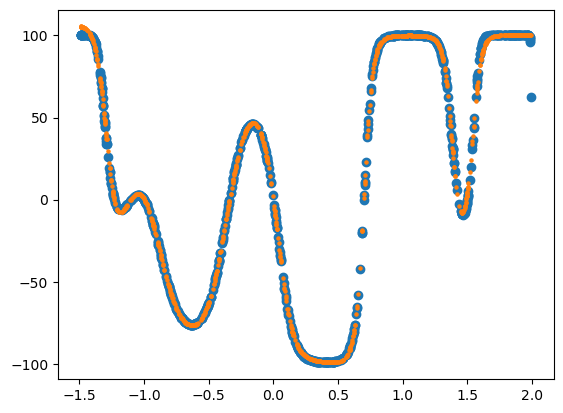

In [153]:
preds_modal = mlp_modal.predict(multimodal_test['x'].to_numpy().reshape(-1,1))
preds_modal_denorm = destandardize_data(preds_modal, parameters_modal)
plt.scatter(multimodal_test['x'], multimodal_test['y'])
plt.scatter(multimodal_test['x'], preds_modal_denorm, s=5)
print('Test MSE:', mlp_modal.mse(multimodal_test['x'], multimodal_test['y'], resize=True, denormalize=parameters_modal))
plt.show()

## Eksperymenty

In [10]:
def method_test(train_set, test_set, batch_size, arch, init, lr, epochs, name, interval=100, cutoff=None, test=False):
    """
    alfa for methods = 0.9
    """
    y_norm, parameters = standardize_data(train_set['y'])
    methods = [None, 'moment', 'rmsprop']
    for method in methods:
        mse_list = []
        mlp = NeuralNetwork(arch, initalization=init)
        history = mlp.train(train_set['x'], y_norm, learning_rate=lr, epochs=epochs, batch_size=batch_size, return_history=True,
                                resize=True, X_test=test_set['x'], y_test=test_set['y'], cutoff=cutoff,
                                denormalize=parameters, info_interval=interval, mute_print=True, optimize=method)
        history.plot_loss(test=test, return_plot=True)
    plt.suptitle(f"{name}, arch: {arch}, lr={lr}")
    plt.legend(methods)
    plt.show()

#### square-large

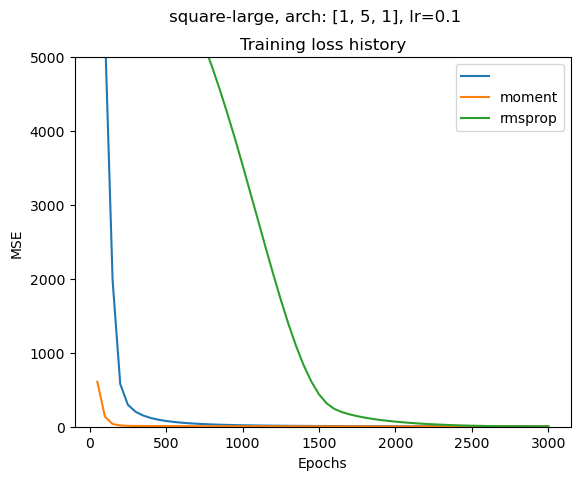

In [9]:
plt.ylim([0,5000])
method_test(square_large_train, square_large_test, 250, [1, 5, 1], 'xavier', lr=0.1, epochs=3000,
           name='square-large', interval=50)

Widać, że rmsprop radzi sobie najgorzej. Sprawdźmy jednak to raz jeszcze, ale na zbiorze testowym i mniejszej skali:

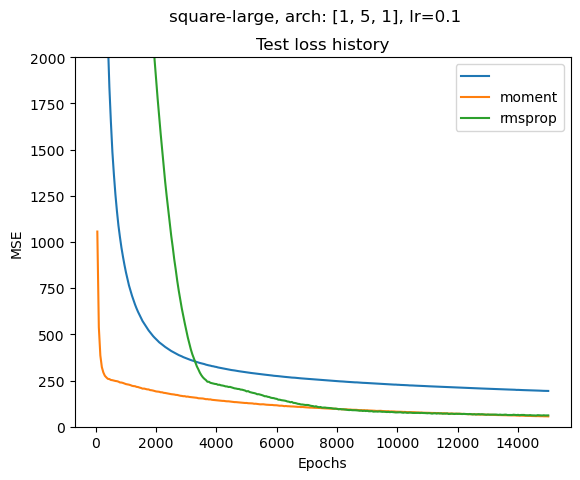

In [15]:
plt.ylim([0,2000])
method_test(square_large_train, square_large_test, 250, [1, 5, 1], 'xavier', lr=0.1, epochs=15000,
           name='square-large', interval=50, test=True)

#### steps-large

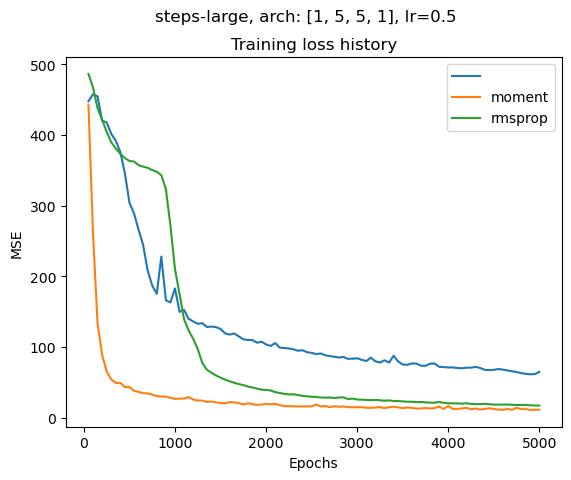

In [27]:
method_test(steps_large_train, steps_large_test, 250, [1, 5, 5, 1], 'he', lr=0.5, epochs=5000,
           name='steps-large', interval=50)

#### multimodal-large

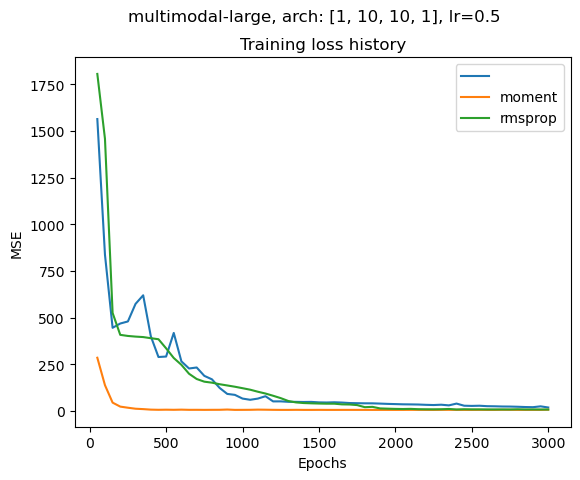

In [8]:
method_test(multimodal_train, multimodal_test, 250, [1, 10, 10, 1], 'xavier', lr=0.5, epochs=3000,
           name='multimodal-large', interval=50)

Widzimy, że uczenie z momentem daje najlepsze wyniki (i najszybciej). Normalizacja gradientu w ogólności też daje lepsze wyniki niż zwykła propagacja wsteczna, ale dopiero od pewnego momentu.